# Verifying generalizability


In [6]:
%cd /home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1

/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1


In [7]:
from src.util import read_results, train_test_validate_split, eval_result, eval_sota_models
from evaluation.util import load_eval_results

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
plt.style.use("/home/pepijn/Documents/uni/y5/thesis/writing/msc-thesis-figures/std-colors.mplstyle")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
result_df = read_results()
train, test, validate = train_test_validate_split(read_results())

train set:
	Records: 210953
	Positive (speedup > 1 with factorizing)/Negative: 39648/171305 = 0.23 s
	Dataset types: ['synthetic' 'hamlet']
\Compute Units: ['v100' 'CPU 08c' 'p100' 'CPU 16c' '1080' 'CPU 32c' '2080' 'a40']
test set:
	Records: 90409
	Positive (speedup > 1 with factorizing)/Negative: 16772/73637 = 0.23 s
	Dataset types: ['synthetic' 'hamlet']
\Compute Units: ['CPU 32c' '2080' 'CPU 16c' '1080' 'CPU 08c' 'v100' 'p100' 'a40']
validate set:
	Records: 11187
	Positive (speedup > 1 with factorizing)/Negative: 1123/10064 = 0.11 s
	Dataset types: ['synthetic' 'hamlet' 'tpc_ai']
\Compute Units: ['p100' 'CPU 32c' 'CPU 16c' 'CPU 08c' '2080' '1080' 'v100' 'a40']


In [9]:
%%capture
merged_results = load_eval_results()

2024-03-29 20:55:42.061 | INFO     | src.util:eval_model:482 - Model <class 'src.estimators.MorpheusFI'>, MorpheusFI
 test cols: Index(['speedup', 'operator', 'num_cores', 'selectivity', 'cardinality_T',
       'cardinality_S', 'join', 'complexity_ratio', 'times_mean',
       'compute_type', 'label', 'parallelism', 'mem_mat_read', 'mem_mat_write',
       'mem_fac_read', 'mem_fac_write', 'comp_scalar_mat', 'comp_lmm_mat',
       'comp_rmm_mat', 'comp_scalar_fac', 'comp_lmm_fac', 'comp_rmm_fac',
       'comp_mat_col_major', 'comp_fac_col_major', 'comp_scalar_dense', '13',
       '14', 'comp_matrix_dense', 'mem_read_scalar_dense',
       'mem_write_scalar_dense', 'mem_read_matrix_dense',
       'mem_write_matrix_dense', 'mem_read_rowsum', 'mem_write_rowsum',
       'mem_read_colsum', 'mem_write_colsum', '24', '25', 'comp_rowsum',
       'comp_colsum', 'comp_mat', 'comp_fac', 'comp_ratio', 'tr', 'fr', 'r_S',
       'c_S', 'TR', 'FR', 'nnz_T', 'nnz_S_sum', 'nnz_S', 'r_T', 'c_T',
       'spa

In [10]:
# test_set_fraction_of_optimal_performance = pd.Series({
#     "XGB.3": 0.956145,
#     "XGB.5": 0.929038,
#     "STAT.1": 0.39195,
#     "STAT.5": 0.301950,
#     "Analytical.1": 0.18,
#     "Analytical.2": 0.0117,
# })

## New (real) datasets
Show performance loss

In [11]:
palette= sns.color_palette("rocket", len(merged_results.model.unique()))

/tmp/ipykernel_60831/1265042618.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["New\nhardware", "Real\ndatasets", "Full"])


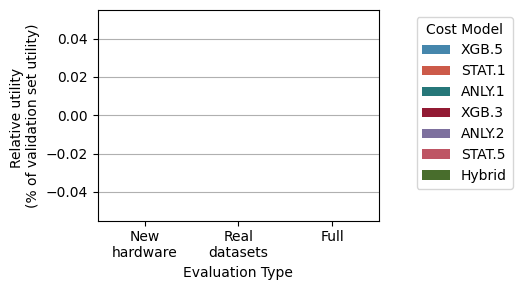

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(0.8 * 8, 3))
plotdf = merged_results[(merged_results.model_type == "own") & (merged_results.eval_type.isin(["new hardware", "real datasets", "full"]))].sort_values("eval_type", ascending=False)
sns.barplot(data=plotdf, y="performance_pct_vs_baseline", x="eval_type", hue="model", ax=ax, )
ax.grid(axis="y")
ax.set_axisbelow(True)
# ax.set_ylim(0., 1.)
ax.legend(title="Cost Model", ncol=1, loc="upper right", bbox_to_anchor=(1.5, 1.0))
ax.set_ylabel("Relative utility \n(% of validation set utility)")
ax.set_xlabel("Evaluation Type")
ax.set_xticklabels(["New\nhardware", "Real\ndatasets", "Full"])

for patch in ax.patches:
    patch.set_edgecolor("white")
    # if patch.get_height() < 0.1:
    #     ax.annotate(
    #         f"{patch.get_height():.2f}",
    #         (patch.get_x() + patch.get_width() / 2.0, patch.get_height()),
    #         ha="center",
    #         va="center",
    #         xytext=(0, 10),
    #         textcoords="offset points",
    #         fontsize=8,
    #         color="black",
    #         rotation=0,
    #     )
fig.tight_layout()
# fig.savefig("/home/pepijn/Documents/uni/y5/thesis/writing/overleaf/chapters/06_evaluation/figures/eval_generalization.pdf", bbox_inches="tight")

## SOTA comparison

/tmp/ipykernel_60831/1709093466.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_right.set_xticklabels(labels=[None])


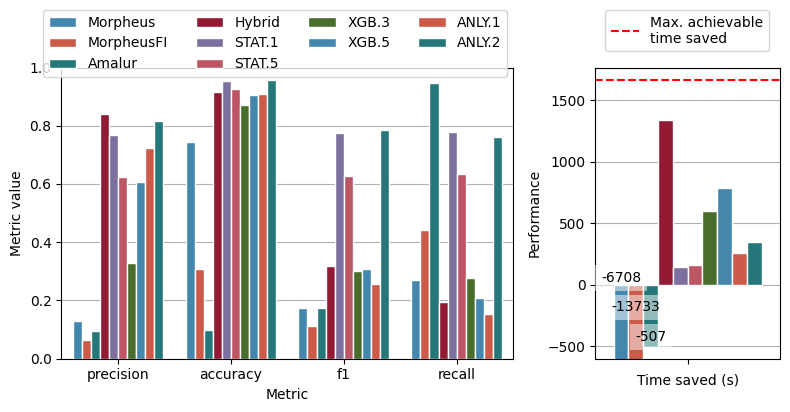

In [13]:
# colors = []
# for c in sns.color_palette("rocket_r", 6):
#     colors.extend([
#                    sns.set_hls_values(c, l=0.4),
#                    c])
# colors.pop(1)

fig, axs = plt.subplot_mosaic("AAB", figsize=(8, 3.7))
melted_df = pd.melt(merged_results, id_vars=["model", "eval_type", 'model_type'], var_name="metric", value_name="metric_value").sort_values("model_type")
max_time_saved = merged_results.y_true_time_saved.max()
min_ylim = -600
def plot_metrics(ax, metrics: list, legend=True):
    ax.set_axisbelow(True)
    ax.grid(axis="y")
    ax = sns.barplot(
        data=melted_df[(melted_df.metric.apply(lambda x: x in metrics)) & (melted_df.eval_type=='full')],
        x="metric",
        y="metric_value",
        hue="model",
        palette=sns.color_palette(n_colors=10),
        ax=ax,
    )
    if not legend:
        ax.get_legend().remove()
    else:
        legend = ax.legend(loc="upper center", bbox_to_anchor=(1.0, 1.1), ncol=5, borderaxespad=-1)
    # Add metric values as text on top of every bar
    for i, p in enumerate(ax.patches):
        p.set_edgecolor("white")
        fmt = ".2f" if abs(p.get_height()) < 1 else ".0f"
        height = p.get_height()
        if height <( min_ylim+100):
            ax.annotate(
                format(p.get_height(),fmt),
                (p.get_x() + p.get_width() / 2.0, 120*i*-2),
                ha="center",
                va="center",
                xytext=(0, 5),
                textcoords="offset points",
                bbox={"facecolor": "white", "alpha": 0.5, "edgecolor": "none"},
            )
    return legend

ax_left = axs["A"]
ax_right = axs["B"]
plot_metrics(ax_left, ["accuracy", "precision", "recall", "f1"], legend=False)
plot_metrics(ax_right, ["y_pred_time_saved"], legend=True)

ax_left.set_xlabel("Metric")
ax_left.set_ylabel("Metric value" )
ax_left.set_ylim(0., 1.)

ax_right.axhline(max_time_saved, ls="--", color="red", label="Max. achievable\ntime saved",)
ax_right.set_ylim(min_ylim, max_time_saved+100)
ax_right.set_xlabel("Time saved (s)")
ax_right.set_ylabel("Performance")
ax_right.set_xticklabels(labels=[None])

handles, labels = ax_right.get_legend_handles_labels()
l1 = fig.legend(handles[:-1], labels[:-1], ncols=4, loc="upper center", bbox_to_anchor=(0.35, 1.1), borderaxespad=0)
ax_right.legend().remove()
l2 = fig.legend([handles[-1]], [labels[-1]], loc="upper center", bbox_to_anchor=(0.865, 1.1), borderaxespad=0)

fig.tight_layout()
# fig.savefig("/home/pepijn/Documents/uni/y5/thesis/writing/overleaf/chapters/06_evaluation/figures/eval_sota_results.pdf", bbox_inches="tight")